In [1]:
import os
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()

algorithm = 'XGB_corr_ratio_ap_0.7'
plt.rcParams['font.family'] = 'Times New Roman'

# train
patents_path='./patents SMILES/'
topology_path='./topology/'
descriptor_path='./descriptor/'
basic_path='./basic/'
df = pd.read_excel('drugbank_extract_filtered.xlsx')
drug_name_list = df['Generic Name'].tolist()
compound_num_list = df['compounds number'].tolist()

drug_list = []
for i in range(0,len(df)):
  one = str(compound_num_list[i]) + '_' + drug_name_list[i] + '.xlsx'
  drug_list.append(one)

drug_list = sorted(drug_list, key=lambda x: int(x.split('_')[0]))
print(len(drug_list))

# ex
JP_patents_path='./JP/patents SMILES/'
JP_topology_path='./JP/topology/'
JP_descriptor_path='./JP/descriptor/'
JP_basic_path='./JP/basic/'
df = pd.read_excel('./JP/japan_drugs_filtered.xlsx')
drug_name_list = df['Generic Name'].tolist()
compound_num_list = df['compounds number'].tolist()

JP_drug_list = []
for i in range(0,len(df)):
  one = str(compound_num_list[i]) + '_' + drug_name_list[i] + '.xlsx'
  JP_drug_list.append(one)

JP_drug_list = sorted(JP_drug_list, key=lambda x: int(x.split('_')[0]))
print(len(JP_drug_list))

781
25


In [2]:
def external(drug_all_basic, X,y,X_ex,y_ex):
    X_df = X
    X = X.values
    X_ex = X_ex.values

    if 'RF' in algorithm:
        model = RandomForestClassifier(random_state=1)
        param_grid = {
            'n_estimators':[300],
            'class_weight':[{1:50,0:1}],
            'max_depth':[6]
        }

    if 'XGB' in algorithm:
        model = xgb.XGBClassifier(seed=1,tree_method = "hist")
        param_grid = {
        'n_estimators':[100],
        'scale_pos_weight':[50],
        'max_depth':[3]
        }

    # 数据预处理
    X = scaler.fit_transform(X)
    X_ex = scaler.transform(X_ex)
    if 'RF' in algorithm:
        X, X_ex = np.nan_to_num(X, nan=0), np.nan_to_num(X_ex, nan=0)
    # print(X)
    # print(X_ex)


    inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
    clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='average_precision', error_score='raise',n_jobs=9)

    # Fit GridSearchCV on the training set
    clf.fit(X, y)

    # Predict probabilities on the ex set
    y_pred_proba = clf.predict_proba(X_ex)

    # print(y_pred_proba)

    # Calculate the confusion matrix
    y_pred = clf.predict(X_ex)
    cm = confusion_matrix(y_ex, y_pred)

    # 保存预测结果
    drug_all_basic = drug_all_basic.assign(y_pred=y_pred)
    # drug_all_basic.to_excel('./JP/external_result.xlsx', index=False)

    # Calculate scores for the fold
    metrics_score = average_precision_score(y_ex, y_pred_proba[:, 1])

    # 排序参数重要性
    best_model = clf.best_estimator_
    feature_importance = best_model.feature_importances_
    sorted_idx = feature_importance.argsort()
    top_sorted_idx = sorted_idx[-10:]

    # 绘制重要参数图表
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_sorted_idx)), feature_importance[top_sorted_idx], align='center', color='gray')
    plt.yticks(range(len(top_sorted_idx)), [X_df.columns[i] for i in top_sorted_idx])
    plt.xlabel('Feature Importance')
    plttitle =  algorithm + ': Top 10 features'
    plt.title(plttitle)
    plt.show()
        

    print('metrics_score',metrics_score)
    print('cm',cm)
    print('positive',(cm[0][1]+cm[1][1])/(cm[1][0]+cm[1][1]+cm[0][0]+cm[0][1]))
    print('accuracy',cm[1][1]/(cm[1][0]+cm[1][1]))


In [3]:
top_features = ['HallKierAlpha', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'VSA_EState5',
'BalabanJ', 'FpDensityMorgan1', 'MinAbsEStateIndex', 'MinEStateIndex',
'qed', 'BCUT2D_MRLOW', 'BCUT2D_MWLOW', 'MinPartialCharge',
'VSA_EState7', 'FpDensityMorgan2', 'fr_aldehyde', 'fr_isocyan', 'Ipc',
'Kappa3', 'fr_nitroso', 'NumRadicalElectrons', 'fr_dihydropyridine',
'fr_hdrzine', 'fr_thiocyan', 'fr_C_S', 'FractionCSP3', 'fr_azide',
'fr_diazo', 'fr_azo', 'fr_barbitur', 'fr_Ar_COO', 'fr_term_acetylene',
'fr_SH', 'fr_quatN', 'fr_isothiocyan', 'fr_benzodiazepine',
'fr_epoxide', 'fr_oxazole', 'fr_phos_acid', 'fr_amidine', 'fr_hdrzone',
'fr_furan', 'fr_oxime', 'fr_imide', 'fr_HOCCN', 'fr_N_O', 'fr_lactam',
'fr_nitro', 'MaxAbsPartialCharge', 'fr_nitro_arom_nonortho',
'fr_thiophene', 'fr_morpholine', 'fr_nitrile', 'fr_sulfone',
'fr_nitro_arom', 'fr_tetrazole', 'fr_alkyl_halide', 'fr_phos_ester',
'BCUT2D_MWHI', 'MinAbsPartialCharge', 'fr_unbrch_alkane', 'fr_ArN',
'SlogP_VSA7', 'fr_allylic_oxid', 'fr_sulfonamd']

In [4]:
def find_closest_thres(lst, target):
    closest_index = None
    min_diff = float('inf')  # 初始化最小差值为正无穷
    
    for i, num in enumerate(lst):
        diff = abs(num - target)  # 计算当前元素与目标值的差值
        
        if diff < min_diff:  # 如果当前差值更小，则更新最小差值和对应的索引
            min_diff = diff
            closest_index = i
    
    return (closest_index + 1)/10

# 选定一个ratio，然后每个药物选择最接近的threshold，做成字典，后续模型参数输入


ratio_df = pd.read_excel('residue_ratio.xlsx')
ratios = [round(i * 0.1, 1) for i in range(1, 10)]

ratio_thres_df = pd.DataFrame()
for drug in drug_list:
    drugname = drug.split('.')[0].split('_')[1]
    dict1={}
    dict1['drug_name'] = drug.split('.')[0].split('_')[1]
    ratio_list = ratio_df[ratio_df['drug_name'] == drugname].values.tolist()[0][1:]
    for ratio in ratios:
        
        pair_threshold = find_closest_thres(ratio_list, ratio)
        dict1[ratio] = pair_threshold
    new_row =  pd.DataFrame(dict1, index=[0])
    ratio_thres_df = pd.concat([ratio_thres_df, new_row], ignore_index=True)

# print(ratio_thres_df)



ratio_df = pd.read_excel('./JP/residue_ratio.xlsx')
ratios = [round(i * 0.1, 1) for i in range(1, 10)]

JP_ratio_thres_df = pd.DataFrame()
for drug in JP_drug_list:
    drugname = drug.split('.')[0].split('_')[1]
    dict1={}
    dict1['drug_name'] = drug.split('.')[0].split('_')[1]
    ratio_list = ratio_df[ratio_df['drug_name'] == drugname].values.tolist()[0][1:]
    for ratio in ratios:
        
        pair_threshold = find_closest_thres(ratio_list, ratio)
        dict1[ratio] = pair_threshold
    new_row =  pd.DataFrame(dict1, index=[0])
    JP_ratio_thres_df = pd.concat([JP_ratio_thres_df, new_row], ignore_index=True)

# print(JP_ratio_thres_df)
        

In [5]:
cutoff=0.7

# 加载训练集
drug_all = pd.DataFrame()
for drug in drug_list:
    basic=pd.read_excel(basic_path+'basic_'+drug)

    cutoff_ = ratio_thres_df.loc[ratio_thres_df['drug_name'] == drug.split('.')[0].split('_')[1], cutoff].values[0]
    topology=pd.read_excel(topology_path+drug.split('.')[0].split('_')[1]+'/tani_ECFP6_'+str(cutoff_)+'_'+drug)

    descriptor=pd.read_excel(descriptor_path+'descriptor_'+drug)
    drug_info = pd.merge(pd.merge(basic, topology, on='c_smiles'), descriptor, on='c_smiles')
        
    drug_all = pd.concat([drug_all, drug_info],axis=0,ignore_index=True)

drug_all = pd.concat([drug_all.iloc[:, :14], drug_all[top_features]],axis=1)
    
drug_all.replace([np.inf, -np.inf], np.nan, inplace=True)


X = drug_all.iloc[:,6:]
y = drug_all.iloc[:,5]

# print(drug_all)


In [6]:
# 加载external
drug_all = pd.DataFrame()
for drug in JP_drug_list:
    basic=pd.read_excel(JP_basic_path+'basic_'+drug)

    cutoff_ = JP_ratio_thres_df.loc[JP_ratio_thres_df['drug_name'] == drug.split('.')[0].split('_')[1], cutoff].values[0]
    topology=pd.read_excel(JP_topology_path+drug.split('.')[0].split('_')[1]+'/tani_ECFP6_'+str(cutoff_)+'_'+drug)

    descriptor=pd.read_excel(JP_descriptor_path+'descriptor_'+drug)
    drug_info = pd.merge(pd.merge(basic, topology, on='c_smiles'), descriptor, on='c_smiles')
        
    drug_all = pd.concat([drug_all, drug_info],axis=0,ignore_index=True)

drug_all = pd.concat([drug_all.iloc[:, :14], drug_all[top_features]],axis=1)
    
drug_all.replace([np.inf, -np.inf], np.nan, inplace=True)


X_ex = drug_all.iloc[:,6:]
y_ex = drug_all.iloc[:,5]

# print(drug_all)


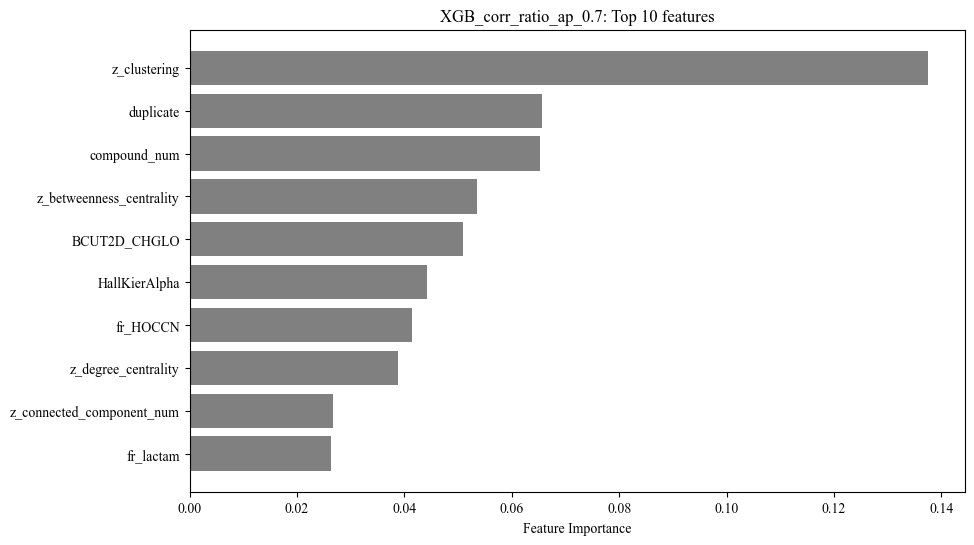

metrics_score 0.17615438274873932
cm [[3661  155]
 [  12   13]]
positive 0.04373860973704764
accuracy 0.52


In [7]:
drug_all_basic = drug_all.iloc[:, :6]

external(drug_all_basic, X,y,X_ex,y_ex)


In [8]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
from rdkit.Chem import inchi
RDLogger.DisableLog('rdApp.*')

def smiles_to_smiles(smiles,basicClean=True,clearCharge=True, clearFrag=True, canonTautomer=True, isomeric=False):
    try:
        clean_mol = Chem.MolFromSmiles(smiles)
        # 除去氢、金属原子、标准化分子
        if basicClean:
            clean_mol = rdMolStandardize.Cleanup(clean_mol) 
        if clearFrag:
        #  仅保留主要片段作为分子
            clean_mol = rdMolStandardize.FragmentParent(clean_mol)
        # 尝试中性化处理分子
        if clearCharge:
            uncharger = rdMolStandardize.Uncharger() 
            clean_mol = uncharger.uncharge(clean_mol)
        # 处理互变异构情形，这一步在某些情况下可能不够完美
        if canonTautomer:
            te = rdMolStandardize.TautomerEnumerator() # idem
            clean_mol = te.Canonicalize(clean_mol)
        #set to True 保存立体信息，set to False 移除立体信息，并将分子存为标准化后的SMILES形式
        stan_smiles=Chem.MolToSmiles(clean_mol, isomericSmiles=isomeric)
    except Exception as e:
        # print (e, smiles)
        return None
    return stan_smiles